In [1]:
import os
from pathlib import Path
import uproot
import numpy as np
import awkward
import pandas as pd
import matplotlib.pyplot as plt
cwd = os.getcwd()

In [2]:
folder = Path('/home/brash/Research/bbcal')
filename =os.path.join(folder, 'bbcal_232.root')
f = uproot.open(filename)

In [3]:
T = f['T']

bb_ps_a = T["bb.ps.a"].array(library="np")
df_bb_ps_a = pd.DataFrame(bb_ps_a,columns=["bb_ps_a"])
df_bb_ps_a = pd.DataFrame(df_bb_ps_a.bb_ps_a.tolist(), index= df_bb_ps_a.index)

So, hardcoding numbers into code is generally a bad thing to do!  We should get the number of events in the file, along with the number of pre-shower blocks, by looking at the size of the dataframe.  Then, we can store those numbers as variables and use them forthwith in our code.  That way, your code should then work for ANY data file, and not just this one.

We should also set variables for the number of bins, and the low and high range that we want to use.  This makes it much easier to adjust these numbers in the future, if we find that we need to (for a different data file, or for other reasons).

For example, when I first plotted these histograms using your original limits of 400 to 800, I found that this lower limit of 400 was actually too large for one of the blocks.  Lowering this number to 300 makes better sense.

In [40]:
nevents = len(df_bb_ps_a)
nblocks = len(df_bb_ps_a.columns)
nbins = 100
xlow = 300
xhigh = 800

print (nevents,nblocks)

342395 54


We see that there are actually 54 blocks in the pre-shower (indexed from 0 to 53), and 342395 events in the file (indexed from 0 to 342394).

OK, so let's look at block 0 first, and see if we can figure out how to create the appropriate plot for
that block.  Once we have that figured out, we can continue on to the rest of the blocks.

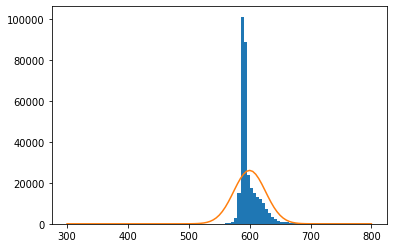

In [41]:
# histogram plot of raw adc for one of the blocks (block 0) for all events
# histogram for 100 bins, from 300 to 800

# First, plot the histogram of the data.
plt.hist(df_bb_ps_a[0][0:nevents],bins=nbins,range=(xlow,xhigh))

# Second, get the bin information for this histogram.  This is CRUCIALLY imporant, as we will need
# it later to create a properly normalized Gaussian to plot on top of this histogram.
#
# If you look at it, bins will be a numpy array that has nbins+1 elements, and which ranges from xlow
# to xhigh.  That is, bins will contain the x-values of the EDGES of each bin in the histogram
#
bins=np.histogram(df_bb_ps_a[0][0:nevents], bins=nbins, range=(xlow,xhigh))[1]

# Third, we need to have a way to limit the range of x-values that will be used to calculate the mean
# and standard deviation of this histogram.  As it turns out, we really only need to make sure that
# the x-value is BELOW the upper limit, xhigh.
#
#  The array called 'below' will be a BOOLEAN array that will be either true or false, depending
#  on whether the condition is met.
#
below = (df_bb_ps_a[0] <= xhigh)

# Fourth, we can now calculate the mean and sigma of this histogram.
#
# This is a bit of an odd syntax, but basically what it says is:  take all of the values in the column
# of the dataframe (db_bb_ps_a[0]) that pass the condition called 'below', and then take the mean of
# only those values.
#
mu = df_bb_ps_a.loc[below,0].mean()
sigma = df_bb_ps_a.loc[below,0].std()


# Fifth, calculate the bin SIZE
dx = (bins[len(bins)-1] - bins[0])/nbins

# Now, finally, we are ready to calculate the amplitude factor for the Gaussian.  A normalized Gaussian
# (i.e. one that has an integral of 1) has a factor 1/(sqrt(2*PI)*sigma) out in front.  Now, we know
# that our Gaussian should integrate not to 1, but rather to nevents.  So, we need certainly to multiply
# by nevents.  So, then the INTEGRAND of the Gaussian integral should be this factor times dx.
# 
# The other factors in the Gaussian are the usual ones.
#
amplitude = (nevents*dx)/(np.sqrt(2*np.pi)*sigma)
xa = -1.0*(bins-mu)**2/(2.0*sigma**2)

ya = amplitude*np.exp(xa)

# Now, we can just plot this Gaussian
plt.plot(bins,ya)
#plt.yscale('log')

# N.B.  This is correct!  The point here is that the INTEGRAL of this orange curve is the same as
# the SUM of all of the events in the bins shown in blue.  The reason the Gaussian is wider than
# you might have anticipated that it should be is that our estimate of sigma above is larger than
# anticipated becuase this histogram is, fundamentally, not Gaussian!  It is a sum of a narrow Gaussian
# corresponding to the pedastel and then a wider distribution above this pedastel that correspond to
# real hits in the detector.

So, the problem that we have now is that a single Gaussian fit, using this approach, does not describe the histogram very well.  What can we do?

First of all, the method that I have used for doing the fit is very much "by hand", where I have specified the fitting function explicitly.  Of course, there are Python libraries that allow us to do this in a much more efficient manner.  Let's first implement the fitting in a more modern way.

We will see that this ends up solving all of our problems all at once!

Length of values, bin_edges =  100 101
Length of bin_centers =  100


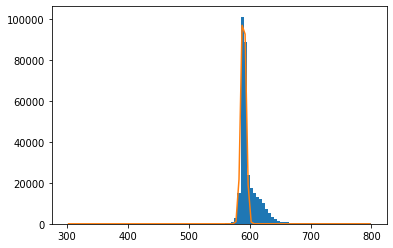

In [42]:
# Step 1:  Get the contents of each bin, and the bin edges.
values, bin_edges=np.histogram(df_bb_ps_a[0][0:nevents], bins=nbins, range=(xlow,xhigh))

print ('Length of values, bin_edges = ',len(values),len(bin_edges))

# Note that the bin_edges array is one element longer than the values array.
# Create an array that contains the bin CENTERS.
bin_centers = bin_edges[:-1] + np.diff(bin_edges)/2

print ('Length of bin_centers = ',len(bin_centers))

# Step 2:  OK, now we have a values array and a bin_centers array of the same length!
#          We can now do a fit using these arrays.
#
#          Since a Gaussian fit is a NON-LINEAR fit, we need to come up with
#          starting values for the fit parameters (amplitude, mu, sigma)

x = bin_centers
y = values

n = sum(y)                          
mean = sum(x*y)/n                   
sigma = np.sqrt(sum(y*(x-mean)**2)/n)

# Step 3:  We need to define a fitting function, which we can change
# as appropriate

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Step 4:  Do the actual fit

from scipy.optimize import curve_fit

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

plt.hist(df_bb_ps_a[0][0:nevents],bins=nbins,range=(xlow,xhigh))
plt.plot(x,gaus(x,*popt),label='fit')


Now we just have to do the same thing, but for all of the blocks.

When one does a loop in Python, for example something like:

for i in range(N):

the way that this works is that i will take on the values from 0 up to and including N-1.  That is, the loop will get executed N times.

So, if we want to split the 54 blocks into a 2D array for plotting purposes, it makes sense to do the first loop 18 times and the second loop 3 times (i.e. 54 = 18 x 3).

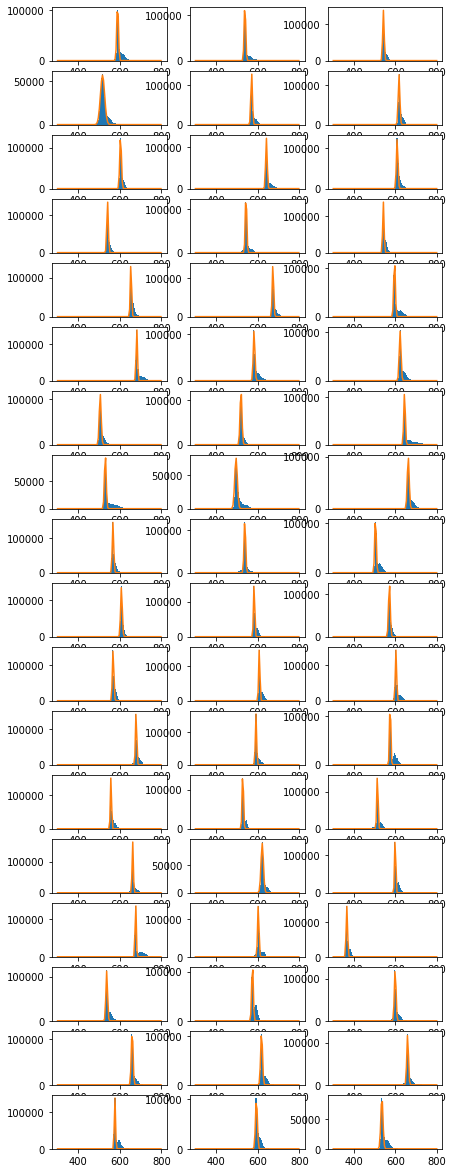

In [43]:
# histogram plots of raw adc for all of blocks for all events 
# histogram for 100 bins, from 400 to 800

from scipy.optimize import curve_fit

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

fig, axs = plt.subplots(18, 3,figsize=(7,21))
for i in range(18):
    for j in range(3):
        
        block = 3*i+j
        
        axs[i][j].hist(df_bb_ps_a[block][0:nevents],bins=nbins,range=(xlow,xhigh))
        
        values, bin_edges=np.histogram(df_bb_ps_a[block][0:nevents], bins=nbins, range=(xlow,xhigh))
        bin_centers = bin_edges[:-1] + np.diff(bin_edges)/2
        
        x = bin_centers
        y = values

        n = sum(y)                          
        mean = sum(x*y)/n                   
        sigma = np.sqrt(sum(y*(x-mean)**2)/n)
        
        popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

        axs[i][j].plot(x,gaus(x,*popt),label='fit')